In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(8,6)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import scipy.io as sio

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.age(1)

import seaborn as sns
import pandas as pd
from astropy.io import fits

sns.set(font_scale=2)
sns.set_style("white", {"axes.grid": "False"})
sns.set_style("ticks")

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

# Step 1: import catalogs and galaxy IDs [and flags]

In [2]:
# SEDs in magnitudes
candels_cat_small = np.loadtxt('../catalogs/CANDELS_GDSS_workshop.dat')

# subtracting 1 from the ID for python indexing
cat_small_ids = candels_cat_small[0:,0] - 1
cat_small_z = candels_cat_small[0:,1]

print(str(cat_small_z.shape[0])+' galaxies in the small catalog.')

#------------------------------------------------------------------------------

candels_cat_z1 = np.loadtxt('../catalogs/CANDELS_GDSS_workshop_z1.dat')

# subtracting 1 from the ID for python indexing
cat_z1_ids = candels_cat_z1[0:,0] - 1
cat_z1_z = candels_cat_z1[0:,1]
print(str(cat_z1_z.shape[0])+' galaxies in the z~1 catalog.')

#------------------------------------------------------------------------------

candels_cat_z3 = np.loadtxt('../catalogs/CANDELS_GDSS_workshop_z3.dat')

# subtracting 1 from the ID for python indexing
cat_z3_ids = candels_cat_z3[0:,0] - 1
cat_z3_z = candels_cat_z3[0:,1]

print(str(cat_z3_z.shape[0])+' galaxies in the z~3 catalog.')

z1flag_cat = np.genfromtxt('../catalogs/flags_z1.dat')
z1flag_ids = z1flag_cat[0:,0]

z1_mask = np.zeros_like(cat_z1_ids)
for i in range(len(z1flag_ids)):
    z1_mask[cat_z1_ids == z1flag_ids[i]-1 ] = 1
    
z3flag_cat = np.genfromtxt('../catalogs/flags_z3.dat')
z3flag_ids = z3flag_cat[0:,0]

z3_mask = np.zeros_like(cat_z3_ids)
for i in range(len(z3flag_ids)):
    z3_mask[cat_z3_ids == z3flag_ids[i]-1 ] = 1

23 galaxies in the small catalog.
371 galaxies in the z~1 catalog.
161 galaxies in the z~3 catalog.


# Step 2: import outputs of all the SED fitting codes.

In [3]:
%run import_scripts/import_p16_fits.py
%run import_scripts/import_dense_basis_fits.py
%run import_scripts/import_fitsed_fits.py
%run import_scripts/import_nima_lephare_fits.py
%run import_scripts/import_marianna_zphot_fits.py
%run import_scripts/import_prospector_fits.py
%run import_scripts/import_bagpipes_fits.py
%run import_scripts/import_cigale_fits_2020.py
%run import_scripts/import_interrogator_fits.py
%run import_scripts/import_speedyMC_fits.py
%run import_scripts/import_eazy_fits.py
%run import_scripts/import_magphys_fits.py
%run import_scripts/import_beagle_fits.py
%run import_scripts/import_sed3fit_fits.py

imported pacifici+16 fits.
imported dense basis fits.
imported FITSED (salmon+15?) fits.
imported Nima's LePhare fits.
imported Marianna's (zPhot) fits.
imported Prospector fits.
imported bagpipes fits.
imported CIGALE files (z=1 fits from Oct 2020, z=3 fits from 27 Feb 2019)
imported interrogator fits.
imported SpeedyMC fits.
imported eazy fits.
imported magphys fits.
imported beagle fits.
imported SED3fit fits.


# Step 3: Take everyone's data and put it in a dataframe, then start the visualization and analysis.

## define dataframes below for Mass, SFR and dust at z~1. Change the dictionary labels here to change the x-tick labels in the violin- and box-plots.

In [4]:
# dataframes for Mass, SFR and dust at z~1

warnings.filterwarnings('ignore')

brett_mass_z3_masked = brett_mass_z3
brett_mass_z3_masked[brett_mass_z3_masked < 0] = np.nan

nima_mass_z3_masked = nima_mass_z3
nima_mass_z3_masked[nima_mass_z3_masked < 0] = np.nan

z3_cat_mass_dict = {'Bagpipes': bagpipes_mass_z3, 
                    'Beagle': beagle_mass_z3,
                    'Cigale':cigale_z3_noagn_mass, # why the factor of 1000 increase? - fixed w/ new fits.
                    'Dense Basis': DB_mass_z3.ravel(), 
                    'FITSED':brett_mass_z3_masked, 
                    'Interrogator':interrogator_mass_z3_pegase.ravel(),
                    'LePhare':nima_mass_z3_masked, 
                    'MAGPHYS':magphys_mass_z3, 
                    'Pacifici+16': cami_mass_z3.ravel(), 
                    'Prospector': prospector_mass_z3,
                    'SED3FIT':sed3fit_mass_z3,
                    'SpeedyMC':speedy_mass_z3,
                    'zPhot':marianna_mass_z3,}
                        
z3_cat_mass = pd.DataFrame(data=z3_cat_mass_dict)

z3_cat_mass[z3_cat_mass < 7] = np.nan

z3_cat_sfr_dict = {'Bagpipes': bagpipes_sfr_z3, 
                    'Beagle': beagle_sfr_z3,
                    'Cigale':cigale_z3_noagn_sfr, # why the factor of 1000 increase? - fixed w/ new fits
                    'Dense Basis': DB_sfr_z3.ravel(), 
                    'FITSED':brett_sfr_z3, 
                    'Interrogator':interrogator_sfr_z3_pegase,
                    'LePhare':nima_sfr_z3, 
                    'MAGPHYS':magphys_sfr_z3, 
                    'Pacifici+16': cami_sfr_z3.ravel(), 
                    'Prospector': prospector_sfr_z3,
                    'SED3FIT':sed3fit_sfr_z3,
                    'SpeedyMC':speedy_sfr_z3,
                    'zPhot':marianna_sfr_z3}

z3_cat_sfr = pd.DataFrame(data=z3_cat_sfr_dict)

z3_cat_sfr[z3_cat_sfr < -3] = -3 # fixes the stretching that a lot of the SFR distributions show due to exrtemely low SFRs

interrogator_Av_z3_pegase[interrogator_Av_z3_pegase < 0] = np.nan

z3_cat_Av_dict = {'Bagpipes': bagpipes_Av_z3,
                    'Beagle': beagle_Av_z3,
                    'Cigale':cigale_z3_noagn_Av,
                    'Dense Basis': DB_Av_z3.ravel(), 
                    'FITSED':brett_Av_z3, 
                    'Interrogator':interrogator_Av_z3_pegase,
                    'MAGPHYS':magphys_Av_z3, 
                    'LePhare':nima_Av_z3, 
                    'Pacifici+16': cami_Av_z3.ravel(), 
                    'Prospector': prospector_Av_z3,
                    'SED3FIT':sed3fit_av_z3,
                    'SpeedyMC':speedy_Av_z3,
                    'zPhot':marianna_Av_z3}
z3_cat_av = pd.DataFrame(data=z3_cat_Av_dict)

print(z3_cat_mass.shape)
print(z3_cat_sfr.shape)
print(z3_cat_av.shape)

(161, 13)
(161, 13)
(161, 13)


# make (and save) plots: 

# quantifying variance in parameter estimates due to different modeling assumptions

In [5]:
mass_z3cat_50 = np.nanmedian(z3_cat_mass,axis=1)
mass_z3cat_16 = np.nanpercentile(z3_cat_mass,16,axis=1)
mass_z3cat_84 = np.nanpercentile(z3_cat_mass,84,axis=1)

z3_cat_sfr[z3_cat_sfr < -3] = np.nan

sfr_z3cat_50 = np.nanmedian(z3_cat_sfr,axis=1)
sfr_z3cat_16 = np.nanpercentile(z3_cat_sfr,16,axis=1)
sfr_z3cat_84 = np.nanpercentile(z3_cat_sfr,84,axis=1)

ssfr_dist = np.log10(10**np.array(z3_cat_sfr) / 10**np.array(z3_cat_mass))

ssfr_z3cat_50 = np.nanmedian(ssfr_dist,axis=1)
ssfr_z3cat_16 = np.nanpercentile(ssfr_dist,16,axis=1)
ssfr_z3cat_84 = np.nanpercentile(ssfr_dist,84,axis=1)

Av_z3cat_50 = np.nanmedian(z3_cat_av,axis=1)
Av_z3cat_16 = np.nanpercentile(z3_cat_av,16,axis=1)
Av_z3cat_84 = np.nanpercentile(z3_cat_av,84,axis=1)

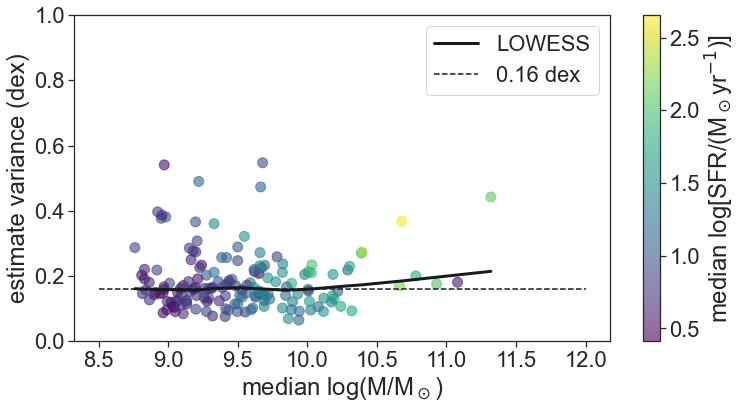

In [6]:
# plot variability for all the galaxies:

plt.figure(figsize=(12,6))
plt.scatter(mass_z3cat_50, (mass_z3cat_84 - mass_z3cat_16)/2,s=100,alpha=0.6,c=sfr_z3cat_50,cmap='viridis')

z3 = lowess((mass_z3cat_84 - mass_z3cat_16)/2,mass_z3cat_50)
plt.plot(z3[0:,0],z3[0:,1],'k-',lw=3,label='LOWESS')
median_val = np.nanmedian((mass_z3cat_84 - mass_z3cat_16)/2)
plt.plot([8.5,12],[median_val,median_val],'k--',label='%.2f dex' %median_val)
plt.xlabel(r'median log(M/M$_\odot$)')
plt.ylabel(r'estimate variance (dex)')
plt.legend(loc='upper right')
plt.ylim(0,1)

clbr = plt.colorbar()
clbr.set_label(r'median log[SFR/(M$_\odot$yr$^{-1}$)]')

plt.savefig("../figures/fig11_var_z3_mass.png", dpi=600, bbox_inches='tight')

plt.show()

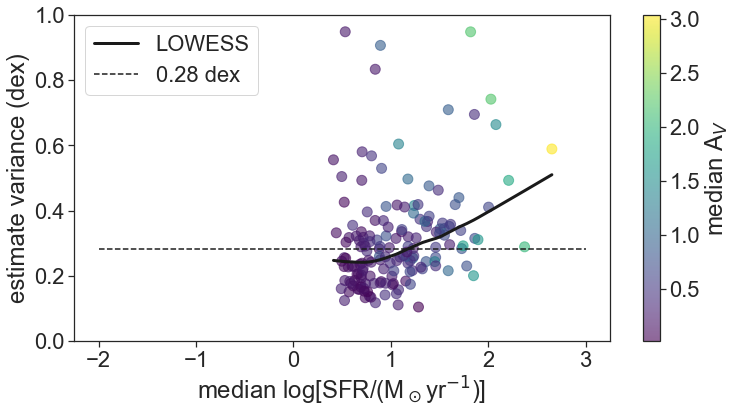

In [7]:
# plot variability for all the galaxies:

plt.figure(figsize=(12,6))
plt.scatter(sfr_z3cat_50, (sfr_z3cat_84 - sfr_z3cat_16)/2,s=100,alpha=0.6,c=Av_z3cat_50,cmap='viridis')

z3 = lowess((sfr_z3cat_84 - sfr_z3cat_16)/2,sfr_z3cat_50)
plt.plot(z3[0:,0],z3[0:,1],'k-',lw=3,label='LOWESS')
median_val = np.nanmedian((sfr_z3cat_84 - sfr_z3cat_16)/2)
plt.plot([-2,3],[median_val,median_val],'k--',label='%.2f dex' %median_val)
plt.xlabel(r'median log[SFR/(M$_\odot$yr$^{-1}$)]')
plt.ylabel(r'estimate variance (dex)')
plt.legend()
plt.ylim(0,1)
#plt.text(8.6,0.5,'z~1 sample',fontsize=24,fontweight='bold')

clbr = plt.colorbar()
clbr.set_label(r'median A$_V$')

plt.savefig("../figures/fig11_var_z3_sfr.png", dpi=600, bbox_inches='tight')

plt.show()

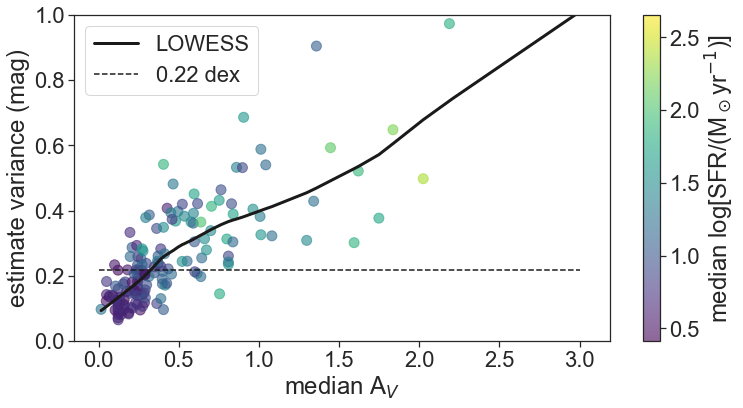

In [8]:
# plot variability for all the galaxies:

plt.figure(figsize=(12,6))
plt.scatter(Av_z3cat_50, (Av_z3cat_84 - Av_z3cat_16)/2,s=100,alpha=0.6,c=sfr_z3cat_50,cmap='viridis')

z3 = lowess((Av_z3cat_84 - Av_z3cat_16)/2,Av_z3cat_50)
plt.plot(z3[0:,0],z3[0:,1],'k-',lw=3,label='LOWESS')
median_val = np.nanmedian((Av_z3cat_84 - Av_z3cat_16)/2)
plt.plot([0,3],[median_val,median_val],'k--',label='%.2f dex' %median_val)
plt.xlabel(r'median A$_V$')
plt.ylabel(r'estimate variance (mag)')
plt.ylim(0,1)
plt.legend()
#plt.text(8.6,0.5,'z~1 sample',fontsize=24,fontweight='bold')

clbr = plt.colorbar()
clbr.set_label(r'median log[SFR/(M$_\odot$yr$^{-1}$)]')

plt.savefig("../figures/fig11_var_z3_av.png", dpi=600, bbox_inches='tight')

plt.show()